# Introduction

This project aims to develop a predictive model that can forecast the next day's SP500 closing price. To do this, a Long Short-Term Memory (LSTM) model has been implemented due to its suitability in capturing long term dependancies in sequential data - in this case, market time series data. As is typical with deep learning architectures, it also has the ability to learn complex patterns in the data and can automatically learn and adjust weights for the most relevant features.

SP500 closing price data from 2014 to 2023 will be used to train and subsequently test the model. In total, the model uses nine features with ten time steps beginning on the previous day: SP500 closing price, volume, MACD, RSI, VIX, USDX, unemployment rate, effective federal funds rate and the consumer sentiment index. This data is then split in to a training, validation and test set and standardised using min-max scaling.

A random search algorithim is utilised for hyperparameter tuning to optimise model performance on the validation set. On completion, the validation set and training set are merged to create a larger training set which the final model is then trained on.




# Libraries

Importing required libraries. Downgrade to tensorflow version 2.12 (2.14 is most up to date) is required to run random search algorithim for hyperparameter tuning.




In [1]:
import pandas as pd
import numpy as np
import tensorflow
import sklearn
import pandas_datareader as pdr
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pywt


In [8]:
!pip install tensorflow==2.12 #Avoids probelms with keras wrapper

#Install instructions
# conda install -c conda-forge tensorflow
# conda install -c conda-forge pywavelets
# pip install yfinance
# conda install -c anaconda scikit-learn
# conda install -c anaconda pandas_datareader

  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)


# Data Preprocessing

MACD and RSI data is obtained from S&P Capital IQ and is loaded in from '**data.xlsx**'. The remainder of the data is sourced dynamically from the '**yfinance**' library and FRED using the '**pandas_datareader**' library.

Individual data frames are then created for each each feature over the time period. To improve model performance, the SP500 closing price data was de-noised using a Haar wavelet transformation.

The **add_timesteps** function is used to add ten time step columns to the individual feature data frames which include the value of that feature on the previous time step for ten steps.

The individual data frames are then merged and rows shifted back one step so that we begin with values at t-1 and not t. The target values, which are the SP500 close prices , are then at t are then also added to the data frame. Finally, NaN values are removed.

Ignore warning when running cell.

In [2]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2023, 10, 1)

#Load in SP500 MACD and RSI data
macd = pd.read_excel('data.xlsx')
macd.set_index('Dates', inplace=True)
macd.rename_axis('Date', inplace=True)
macd.columns = ['MACD', 'RSI']
rsi = pd.DataFrame(macd.pop('RSI'), columns=['RSI'])


#Get Unemployment and EFFR
unemployment = pdr.get_data_fred('UNRATE', start_date, end_date)
effr = pdr.get_data_fred('EFFR', start_date, end_date)
effr = effr.dropna()
umcsent = pdr.get_data_fred('UMCSENT',start_date,end_date)


#Convert Unemployment and Consumer Sentiment Index frequency to daily
unemployment = unemployment.asfreq('D', method='ffill')
umcsent = umcsent.asfreq('D', method='ffill' )


#Creating individual SP500, USDX, VIX data frames with relevant columns
sp500 = yf.download('^GSPC', start_date, end_date,progress = False)
usdx = yf.download('DX-Y.NYB', start_date, end_date,progress=False)
vix = yf.download('^VIX', start_date, end_date,progress = False)

volume = sp500[['Volume']]
sp500 = sp500[['Close']]
usdx = usdx[['Close']]
vix = vix[['Close']]
target = sp500[['Close']]

volume.columns=['Volume']
sp500.columns=['SP500 Close']
usdx.columns=['USDX']
vix.columns=['VIX']
target.columns=['Target']


#Denoise close prices using Haar wavelet transformation
close_prices = sp500['SP500 Close'].values
level = 3
coeffs = pywt.wavedec(close_prices, 'haar', level=level)
threshold = 0.2
denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
denoised_signal = pywt.waverec(denoised_coeffs, 'haar')[:len(close_prices)]
sp500['SP500 Close'] = denoised_signal.copy()


#Define function to add ten time steps to each feature data frame
def add_timesteps(df, column_name, n_periods):
    for i in range(1, n_periods + 1):
      with pd.option_context('mode.chained_assignment', None):
        col_name = f'{column_name} t-{i+1}'
        df.loc[:, col_name] = df[column_name].shift(i)

add_timesteps(sp500,'SP500 Close',10)
add_timesteps(usdx,'USDX',10)
add_timesteps(vix,'VIX',10)
add_timesteps(macd,'MACD',10)
add_timesteps(rsi,'RSI',10)
add_timesteps(unemployment,'UNRATE',10)
add_timesteps(effr,'EFFR',10)
add_timesteps(umcsent,'UMCSENT',10)
add_timesteps(volume,'Volume',10)


#Create data frame using only rows where SP500 Close has a value
df = sp500
for dataframe in [volume,macd,rsi,vix,usdx,unemployment,effr,umcsent]:
  df = pd.merge(df, dataframe, left_index=True, right_index=True, how='left')


#Create final data frame where each feature is shifted back one time period
df = df.shift(1)
df = pd.merge(df,target,left_index=True,right_index=True,how='left')


#Drop random rows containing na values
df = df.dropna()

df


<ipython-input-2-5c1e887f7e56>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['SP500 Close'] = denoised_signal.copy()


,SP500 Close,SP500 Close t-2,SP500 Close t-3,SP500 Close t-4,SP500 Close t-5,SP500 Close t-6,SP500 Close t-7,SP500 Close t-8,SP500 Close t-9,SP500 Close t-10,...,UMCSENT t-3,UMCSENT t-4,UMCSENT t-5,UMCSENT t-6,UMCSENT t-7,UMCSENT t-8,UMCSENT t-9,UMCSENT t-10,UMCSENT t-11,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-17,1845.707172,1847.997162,1838.780005,1819.299951,1842.187152,1837.747162,1837.389990,1837.638584,1826.811441,1831.611416,...,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,1838.699951
2014-01-21,1838.799951,1845.707172,1847.997162,1838.780005,1819.299951,1842.187152,1837.747162,1837.389990,1837.638584,1826.811441,...,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,1843.800049
2014-01-22,1843.841470,1838.799951,1845.707172,1847.997162,1838.780005,1819.299951,1842.187152,1837.747162,1837.389990,1837.638584,...,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,1844.859985
2014-01-23,1844.618564,1843.841470,1838.799951,1845.707172,1847.997162,1838.780005,1819.299951,1842.187152,1837.747162,1837.389990,...,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,1828.459961
2014-01-24,1828.418540,1844.618564,1843.841470,1838.799951,1845.707172,1847.997162,1838.780005,1819.299951,1842.187152,1837.747162,...,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,81.2,1790.290039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,4320.301480,4329.958579,4402.241617,4443.708774,4453.346942,4450.419824,4504.717255,4467.339941,4461.941324,4487.218540,...,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,4337.439941
2023-09-26,4337.057099,4320.301480,4329.958579,4402.241617,4443.708774,4453.346942,4450.419824,4504.717255,4467.339941,4461.941324,...,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,4273.529785
2023-09-27,4273.429785,4337.057099,4320.301480,4329.958579,4402.241617,4443.708774,4453.346942,4450.419824,4504.717255,4467.339941,...,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,67.9,4274.509766


**df** is then split in to a training, validation and test set usng a 80:10:10 split.


In [3]:
train = df.iloc[:round(len(df)*0.80)]
val = df.iloc[round(len(df)*0.8):round(len(df)*0.9)]
test = df.iloc[round(len(df)*0.9):]



Features in the train, validation and test set are then scaled using the MinMaxScaler and the index is reset to add the date as a column.

In [4]:
from sklearn.preprocessing import MinMaxScaler

def scale(train, *dfs):
  scaler = MinMaxScaler()
  train_scaled = scaler.fit_transform(train)
  train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)

  lst = []
  for df in dfs:
    scaled = scaler.transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
    lst.append(scaled)

  return train_scaled, *lst


train_scaled, val_scaled, test_scaled = scale(train,val,test)

train_scaled.reset_index(inplace=True)
val_scaled.reset_index(inplace=True)
test_scaled.reset_index(inplace=True)


Each scaled data set is then converted to three tensors and reshaped for input to the LSTM model. The features tensor must have dimesnions (number of rows, number of timesteps, number of features)

In [5]:
def to_tensors(df):
  dates = df.to_numpy()[:,0]
  features = df.to_numpy()[:,1:100]
  features = features.reshape(len(df),11,9)  #Although 10 timesteps were defined in the add_timesteps function, 11 are used here as using shift() on df gave an extra step
  targets = df.to_numpy()[:,-1]

  return dates, features.astype(np.float32), targets.astype(np.float32)  #astype(np.float32) fixes error which occurs when training model

train_dates, train_features, train_targets = to_tensors(train_scaled)
val_dates, val_features, val_targets = to_tensors(val_scaled)
test_dates, test_features, test_targets = to_tensors(test_scaled)



# Building Model

The LSTM model is constructed using one LSTM layer, two fully connected layers and an output layer with one neuron. The hyperparamters used in this model were initally set at different values than they are currently - the paramters currently in use were chosen based off of the results of the random search in the hyperparameter tuning section, and as expected, led to better performance.

Early stopping is used as the validation loss for this model tends to converge quite quickly (usually within ~10 epochs). This prevents overfitting by halting learning if performance on the validation set begins to decrease even if performance on the training set is still increasing.

When compiled, the model is fit to the data in the training set.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer(input_shape= (11,9)))
model.add(LSTM(150))
model.add(Dense(50,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(train_features, train_targets, validation_data=(val_features, val_targets), epochs=20, batch_size=64, callbacks=[early_stopping])



Epoch 1/20
31/31 [==============================] - 5s 52ms/step - loss: 0.0575 - mean_absolute_error: 0.1862 - val_loss: 0.0678 - val_mean_absolute_error: 0.2239
Epoch 2/20
31/31 [==============================] - 1s 37ms/step - loss: 0.0205 - mean_absolute_error: 0.1186 - val_loss: 0.0163 - val_mean_absolute_error: 0.1085
Epoch 3/20
31/31 [==============================] - 2s 58ms/step - loss: 0.0047 - mean_absolute_error: 0.0547 - val_loss: 0.0410 - val_mean_absolute_error: 0.1881
Epoch 4/20
31/31 [==============================] - 2s 56ms/step - loss: 0.0023 - mean_absolute_error: 0.0364 - val_loss: 0.0047 - val_mean_absolute_error: 0.0559
Epoch 5/20
31/31 [==============================] - 1s 45ms/step - loss: 0.0014 - mean_absolute_error: 0.0294 - val_loss: 0.0057 - val_mean_absolute_error: 0.0604
Epoch 6/20
31/31 [==============================] - 1s 34ms/step - loss: 0.0017 - mean_absolute_error: 0.0314 - val_loss: 0.0114 - val_mean_absolute_error: 0.0983
Epoch 7/20
31/31 [====

As the model output predictions are scaled and in the form of a NumPy array, a function is defined to rescale the values to their original magnitude and return a list of predictions.

In [9]:
def get_predictions_as_list(model,features_set):
  scaler = MinMaxScaler()
  scaler.fit_transform(train.iloc[:,-1].values.reshape(-1, 1))

  predictions = model.predict(features_set).flatten()
  predictions = predictions.reshape(-1, 1)
  predictions = scaler.inverse_transform(predictions)
  predictions = predictions.flatten().tolist()

  return predictions

predictions = get_predictions_as_list(model,val_features)


8/8 [==============================] - 1s 8ms/step


To get a better idea of the performance of the model if it was to be implemented in a trading strategy, the **get_accuracy** function is created. This function returns the proportion of time the model correctly predicts the direction of the the next day's price movement.

In [10]:
def get_accuracy(predictions,target_set):
  scaler = MinMaxScaler()
  scaler.fit_transform(train.iloc[:,-1].values.reshape(-1, 1))
  targets = scaler.inverse_transform(target_set.reshape(-1,1)).flatten().tolist()

  price_movement = [1 if targets[i] > targets[i-1] else 0 for i in range(1, len(targets))]
  pred_movement = [1 if predictions[i] > predictions[i-1] else 0 for i in range(1, len(predictions))]
  same = [1 if pm == pm_pred else 0 for pm, pm_pred in zip(price_movement, pred_movement)]

  from collections import Counter
  counts = Counter(same)
  values = {count:value for count,value in counts.items()}

  return (values[1] / sum(values.values()))


The model's performance on the validation set is plotted below. Visually, the model follows the target close prices well and has a low RMSE and MAE of 165 and 133 respectively. Looking at the accuracy, it is only slightly better than 50:50 at ~51%.

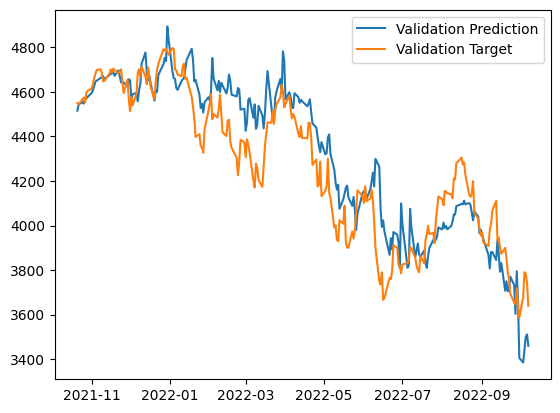

8/8 [==============================] - 0s 8ms/step
RMSE: 150.66472479147475  MAE: 117.56664433755165  Accuracy: 0.5145228215767634


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.plot(val_dates,predictions)
plt.plot(val_dates,val['Target'])
plt.legend(['Validation Prediction', 'Validation Target'])
plt.show()

targets = val.iloc[:,-1]
rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
accuracy = get_accuracy(get_predictions_as_list(model,val_features),val_targets)

print('RMSE:',rmse,' MAE:',mae,' Accuracy:',accuracy)


# Hyperparameter Tuning

*Note: I have found this code will only run with Tensorflow 2.12, pip install at top of notebook*

A random search is used to iterate through multiple combinations of hyperparameters and evaluate the performance of each to get a good approximation of the hyperparamters which minimise the validation loss.

A parameter space is defined with different combinations of hyperparamters for the random search to select from.

A function is created to build an LSTM model with the same architecture as the model above and this is then wrapped as a Keras Regressor for input to **RandomizedSearchCV()**. The search then iterates over random combinations of the hyperparameters in the parameter space and returns the paramaters with the best performance.

This code can take a while to run as it has to fit 100 models. The **n_iter** parameter can be changed from 20 to a lower number to speed the code up and get an idea of the output. I have included an image of the output with 20 iterations in the project file.




In [ ]:
#Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

parameter_space = {
    'lstm_neurons': [50, 100, 150],
    'dense1_neurons': [50, 100, 150],
    'dense2_neurons': [32, 64, 128],
    'learning_rate': [0.001, 0.01],
    'epochs': [20, 40, 60],
    'batch_size': [16, 32, 64]
}

#Function to create model with same architecture as model above
def create_lstm_model(lstm_neurons=100, dense1_neurons=100, dense2_neurons=64, learning_rate=0.001, epochs=20, batch_size=32):
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(train_features.shape[1], train_features.shape[2])))
    model.add(Dense(dense1_neurons, activation='relu'))
    model.add(Dense(dense2_neurons, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_error'])
    return model

#Create Keras Regressor
keras_regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

#Create ranomized search
random_search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=parameter_space,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=3)


random_search.fit(train_features, train_targets)

print(random_search.best_params_)

# Model Performance on Test Set

With the model hyperparamters tuned, the validation set is then added into the training set.

In [12]:
#Creating new train and test set
train = df.iloc[:round(len(df)*0.90)]
test = df.iloc[round(len(df)*0.9):]

#Scale
train_scaled, test_scaled = scale(train,test)
train_scaled.reset_index(inplace=True)
test_scaled.reset_index(inplace=True)

#Split into tensors
train_dates, train_features, train_targets = to_tensors(train_scaled)
test_dates, test_features, test_targets = to_tensors(test_scaled)


Model retrained on new training set and accuracy is printed.

Epoch 1/20
35/35 [==============================] - 2s 47ms/step - loss: 0.0013 - mean_absolute_error: 0.0278
Epoch 2/20
35/35 [==============================] - 2s 56ms/step - loss: 0.0016 - mean_absolute_error: 0.0305
Epoch 3/20
35/35 [==============================] - 2s 56ms/step - loss: 0.0010 - mean_absolute_error: 0.0241
Epoch 4/20
35/35 [==============================] - 1s 41ms/step - loss: 0.0010 - mean_absolute_error: 0.0241
Epoch 5/20
35/35 [==============================] - 1s 30ms/step - loss: 0.0012 - mean_absolute_error: 0.0259
Epoch 6/20
35/35 [==============================] - 1s 27ms/step - loss: 0.0013 - mean_absolute_error: 0.0265
Epoch 7/20
35/35 [==============================] - 1s 27ms/step - loss: 0.0012 - mean_absolute_error: 0.0259
Epoch 8/20
8/8 [==============================] - 0s 10ms/step


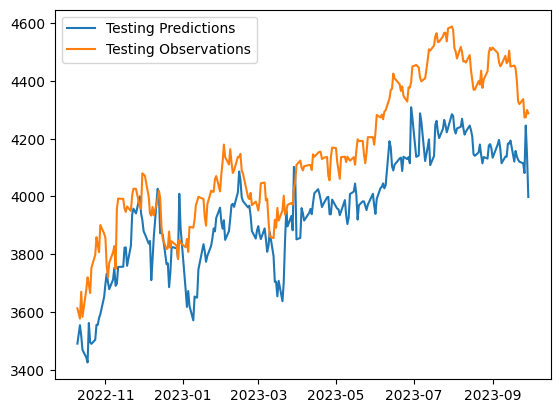

Accuracy: 0.5454545454545454


In [13]:
#Fit model to new training set
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(train_features, train_targets, epochs=20,batch_size=64,callbacks=[early_stopping])

predictions = get_predictions_as_list(model,test_features)

plt.plot(test_dates,predictions)
plt.plot(test_dates,test['Target'])
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

print('Accuracy:',get_accuracy(predictions,test_targets))



Due to the randomness inherent in training a model through random weight initialisation etc., the model will be slightly different every time it is fit. This can be seen by observing the shape of the plot and the value of metrics when repeatedly fitting the model. In the interest of reproducability, I have ran the above model multiple times and saved the best observed model configuration i.e the weights the model decided on, to **final_model.h5** in the project file.


In [14]:
from tensorflow.keras.models import load_model

final_model = load_model('final_model.h5') #Load the final model

final_model.fit(train_features,train_targets,epochs=20, batch_size=64, callbacks=[early_stopping])

predictions = get_predictions_as_list(final_model,test_features)




Epoch 1/20
35/35 [==============================] - 3s 30ms/step - loss: 0.0031 - mean_absolute_error: 0.0421
Epoch 2/20
35/35 [==============================] - 1s 30ms/step - loss: 0.0018 - mean_absolute_error: 0.0305
Epoch 3/20
35/35 [==============================] - 1s 38ms/step - loss: 0.0014 - mean_absolute_error: 0.0286
Epoch 4/20
35/35 [==============================] - 2s 67ms/step - loss: 6.8972e-04 - mean_absolute_error: 0.0196
Epoch 5/20
35/35 [==============================] - 2s 71ms/step - loss: 8.2051e-04 - mean_absolute_error: 0.0214
Epoch 6/20
35/35 [==============================] - 2s 49ms/step - loss: 9.1936e-04 - mean_absolute_error: 0.0219
Epoch 7/20
35/35 [==============================] - 1s 35ms/step - loss: 6.4208e-04 - mean_absolute_error: 0.0186
Epoch 8/20
35/35 [==============================] - 1s 34ms/step - loss: 0.0010 - mean_absolute_error: 0.0240
Epoch 9/20
35/35 [==============================] - 1s 41ms/step - loss: 8.5292e-04 - mean_absolute_erro

Looking at the below plot, the model perfroms well on the test set and accurately captures the trends in price movement although at a slightly lower level. The RMSE and MAE are still low (compared against the magnitude of the actual closing price) at 298 and 277 respectively. The model accuracy is improved on that of the validation set at around ~53%.

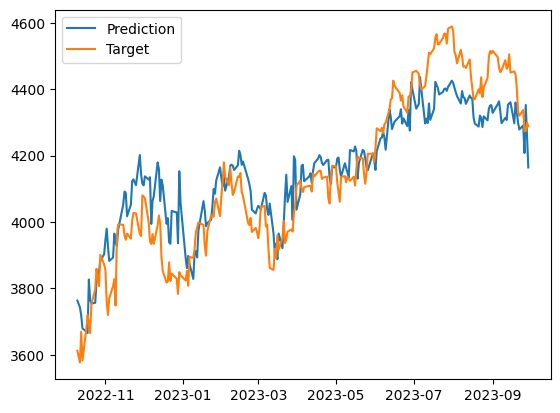

RMSE: 104.74947366243923  MAE: 86.85702803497942  Accuracy: 0.5247933884297521


In [15]:
#Evaluate final model
from sklearn.metrics import mean_squared_error, mean_absolute_error

targets = test.iloc[:,-1]

rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
accuracy = get_accuracy(predictions, test_targets)

plt.plot(test_dates,predictions)
plt.plot(test_dates,test['Target'])
plt.legend(['Prediction', 'Target'])
plt.show()

print('RMSE:',rmse,' MAE:',mae,' Accuracy:',accuracy)

Finally, the model performance over the training, validation and test set is plotted.

8/8 [==============================] - 0s 10ms/step


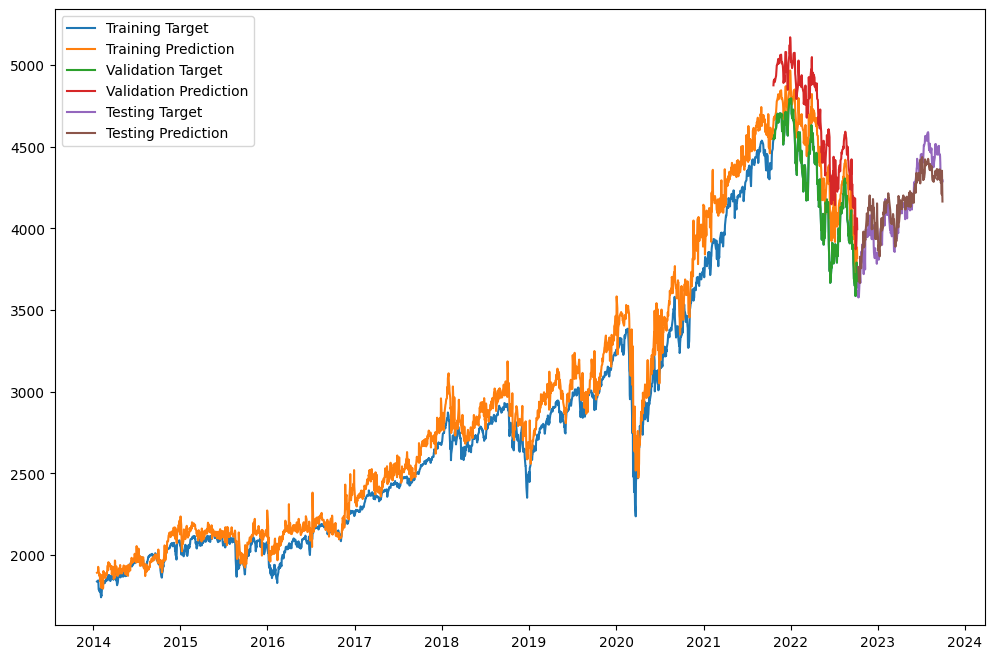

In [16]:
train_targets = train.iloc[:,-1]
val_targets = val.iloc[:,-1]
test_targets = test.iloc[:,-1]

train_predictions = get_predictions_as_list(final_model,train_features)
val_predictions =  get_predictions_as_list(final_model,val_features)
test_predictions = get_predictions_as_list(final_model,test_features)

plt.figure(figsize=(12, 8))
plt.plot(train_dates, train_targets)
plt.plot(train_dates, train_predictions)
plt.plot(val_dates, val_targets)
plt.plot(val_dates, val_predictions)
plt.plot(test_dates, test_targets)
plt.plot(test_dates, test_predictions)
plt.legend(['Training Target',
            'Training Prediction',
            'Validation Target',
            'Validation Prediction',
            'Testing Target',
            'Testing Prediction'])
plt.show()

